In [9]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
import pandas as pd
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import precision_score

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

x_train shape: (60000, 28, 28, 1), y_train shape: (60000,)


In [10]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

pca = PCA(n_components=20)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

In [11]:
def apply_hog_fixed(images):
    hog_features = []
    for img in images:
        feature, _= hog(img, orientations=9, pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2), visualize=True, channel_axis=2)
        hog_features.append(feature)
    return np.array(hog_features)

hog_features_train = apply_hog_fixed(x_train)
hog_features_test = apply_hog_fixed(x_test)

print(f"HOG Features Train Shape: {hog_features_train.shape}")
print(f"HOG Features Test Shape: {hog_features_test.shape}")

HOG Features Train Shape: (60000, 144)
HOG Features Test Shape: (10000, 144)


## 3.1

In [13]:
scaler = StandardScaler()

scaler.fit(x_train_pca)

x_train_pca_standardized = scaler.transform(x_train_pca)

x_test_pca_standardized = scaler.transform(x_test_pca)


scaler_hog = StandardScaler()
x_train_hog_standardized = scaler_hog.fit_transform(hog_features_train)
x_test_hog_standardized = scaler_hog.transform(hog_features_test)

x_train_combined = np.hstack((x_train_pca_standardized, x_train_hog_standardized))
x_test_combined = np.hstack((x_test_pca_standardized, x_test_hog_standardized))

variance_threshold = VarianceThreshold(threshold=1)
x_train_variance = variance_threshold.fit_transform(x_train_combined)
x_test_variance = variance_threshold.transform(x_test_combined)

# print("Dimensiuni înainte și după Variance Threshold:")
# print(f"Dimensiuni train înainte: {x_train_combined.shape}, după: {x_train_variance.shape}")
# print(f"Dimensiuni test înainte: {x_test_combined.shape}, după: {x_test_variance.shape}")


select_percentile = SelectPercentile(f_classif, percentile=70)
x_train_final = select_percentile.fit_transform(x_train_variance, y_train)
x_test_final = select_percentile.transform(x_test_variance)

print(f"Dimensiuni finale: Train: {x_train_final.shape}, Test: {x_test_final.shape}")



Dimensiuni finale: Train: (60000, 61), Test: (10000, 61)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(128, activation='relu', input_shape=(x_train_final.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')  # 10 clase în Fashion-MNIST
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_final, y_train, validation_data=(x_test_final, y_test), epochs=20, batch_size=64)


Epoch 1/20
938/938 [==============================] - 3s 2ms/step - loss: 0.6397 - accuracy: 0.7646 - val_loss: 0.5009 - val_accuracy: 0.8113
Epoch 2/20
938/938 [==============================] - 2s 2ms/step - loss: 0.4937 - accuracy: 0.8142 - val_loss: 0.4723 - val_accuracy: 0.8214
Epoch 3/20
938/938 [==============================] - 2s 2ms/step - loss: 0.4632 - accuracy: 0.8251 - val_loss: 0.4534 - val_accuracy: 0.8297
Epoch 4/20
938/938 [==============================] - 2s 2ms/step - loss: 0.4477 - accuracy: 0.8295 - val_loss: 0.4550 - val_accuracy: 0.8301
Epoch 5/20
938/938 [==============================] - 2s 2ms/step - loss: 0.4322 - accuracy: 0.8371 - val_loss: 0.4364 - val_accuracy: 0.8343
Epoch 6/20
938/938 [==============================] - 2s 2ms/step - loss: 0.4229 - accuracy: 0.8392 - val_loss: 0.4281 - val_accuracy: 0.8381
Epoch 7/20
938/938 [==============================] - 2s 2ms/step - loss: 0.4163 - accuracy: 0.8428 - val_loss: 0.4313 - val_accuracy: 0.8362
Epoch 

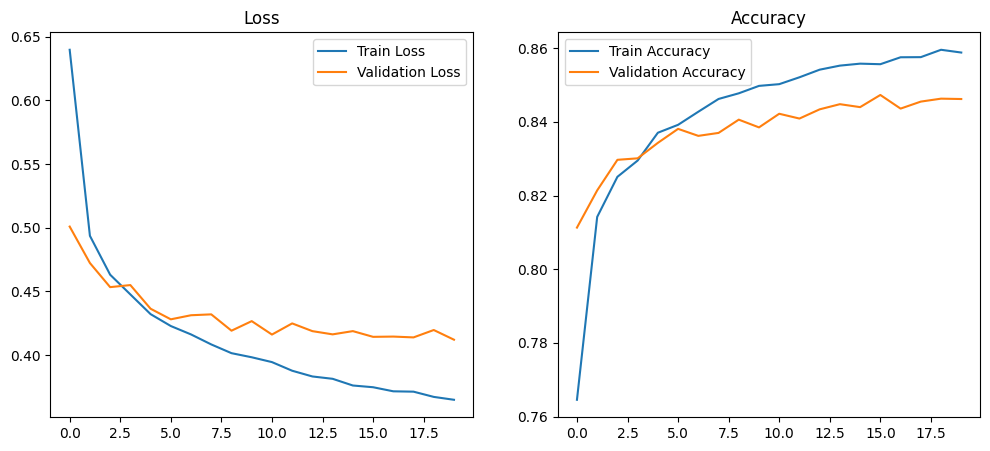

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1000
           1       0.97      0.95      0.96      1000
           2       0.77      0.72      0.74      1000
           3       0.84      0.88      0.86      1000
           4       0.74      0.76      0.75      1000
           5       0.93      0.92      0.92      1000
           6       0.62      0.60      0.61      1000
           7       0.89      0.90      0.90      1000
           8       0.96      0.96      0.96      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



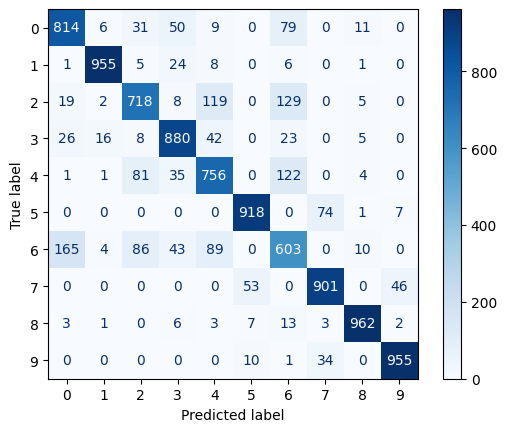

In [16]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

y_pred = np.argmax(model.predict(x_test_final), axis=1)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.show()


## 3.2

In [17]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Normalizează datele
x_train_flat = x_train_flat / 255.0
x_test_flat = x_test_flat / 255.0

print(f"Dimensiuni după liniarizare: Train: {x_train_flat.shape}, Test: {x_test_flat.shape}")


Dimensiuni după liniarizare: Train: (60000, 784), Test: (10000, 784)


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),  # 784 = 28x28
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')  # 10 clase
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [19]:
history = model.fit(x_train_flat, y_train, validation_data=(x_test_flat, y_test), epochs=20, batch_size=64)


Epoch 1/20
938/938 [==============================] - 4s 3ms/step - loss: 0.9834 - accuracy: 0.6363 - val_loss: 0.6385 - val_accuracy: 0.7700
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 0.6069 - accuracy: 0.7760 - val_loss: 0.5479 - val_accuracy: 0.7958
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 0.5309 - accuracy: 0.8074 - val_loss: 0.4941 - val_accuracy: 0.8185
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 0.4838 - accuracy: 0.8266 - val_loss: 0.4606 - val_accuracy: 0.8336
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 0.4523 - accuracy: 0.8373 - val_loss: 0.4488 - val_accuracy: 0.8377
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 0.4314 - accuracy: 0.8457 - val_loss: 0.4266 - val_accuracy: 0.8447
Epoch 7/20
938/938 [==============================] - 3s 3ms/step - loss: 0.4125 - accuracy: 0.8507 - val_loss: 0.4165 - val_accuracy: 0.8480
Epoch 

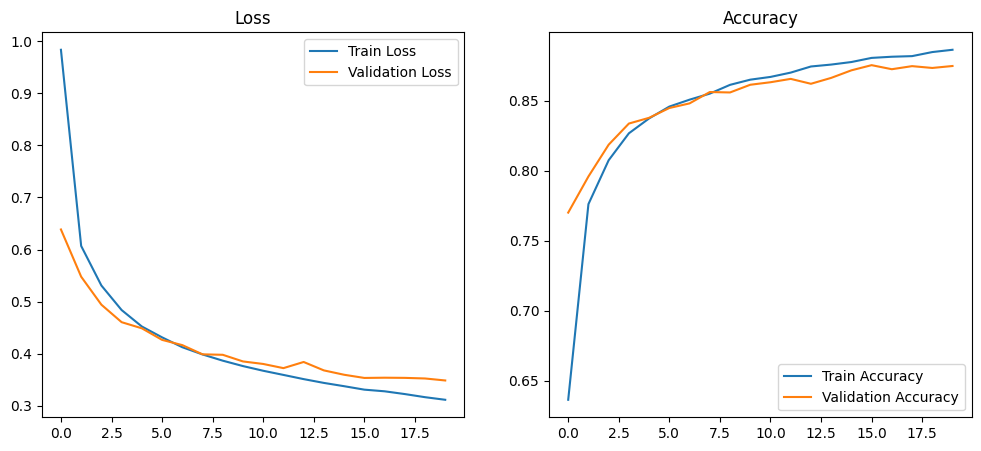

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1000
           1       0.98      0.97      0.98      1000
           2       0.76      0.83      0.79      1000
           3       0.86      0.90      0.88      1000
           4       0.85      0.69      0.76      1000
           5       0.99      0.92      0.95      1000
           6       0.68      0.69      0.69      1000
           7       0.91      0.96      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.95      0.96      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



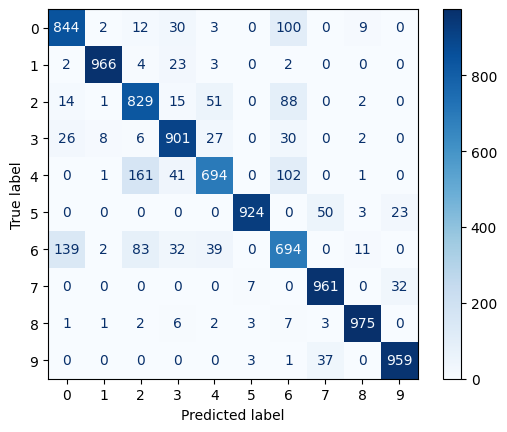

In [21]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import numpy as np

# Preziceri pe datele de test
y_pred = np.argmax(model.predict(x_test_flat), axis=1)

# Raport și matrice de confuzie
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.show()


## 3.3

## 3.4

In [23]:
from tensorflow.image import resize
import numpy as np

# Transformă imaginile grayscale în RGB
x_train_rgb = np.repeat(x_train, 3, axis=-1)
x_test_rgb = np.repeat(x_test, 3, axis=-1)

# Rescalează imaginile la dimensiunea 32x32
x_train_resized = np.array([resize(img, (32, 32)).numpy() for img in x_train_rgb])
x_test_resized = np.array([resize(img, (32, 32)).numpy() for img in x_test_rgb])

print(f"Dimensiuni imagini după transformare: {x_train_resized.shape}, {x_test_resized.shape}")


Dimensiuni imagini după transformare: (60000, 32, 32, 3), (10000, 32, 32, 3)


In [24]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Încarcă modelul ResNet-18 pre-antrenat
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Blochează straturile pre-antrenate
for layer in base_model.layers:
    layer.trainable = False

# Adaugă straturi personalizate pentru clasificare
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


94765736/94765736 [==============================] - 3s 0us/step


In [25]:
from tensorflow.keras.optimizers import SGD

model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train_resized, y_train, validation_data=(x_test_resized, y_test), epochs=20, batch_size=64)


Epoch 1/20
938/938 [==============================] - 121s 126ms/step - loss: 1.2748 - accuracy: 0.5398 - val_loss: 1.0175 - val_accuracy: 0.6259
Epoch 2/20
938/938 [==============================] - 114s 122ms/step - loss: 0.9206 - accuracy: 0.6619 - val_loss: 0.8664 - val_accuracy: 0.6936
Epoch 3/20
938/938 [==============================] - 124s 133ms/step - loss: 0.8379 - accuracy: 0.6892 - val_loss: 0.7973 - val_accuracy: 0.7095
Epoch 4/20
938/938 [==============================] - 117s 125ms/step - loss: 0.7872 - accuracy: 0.7075 - val_loss: 0.8078 - val_accuracy: 0.7017
Epoch 5/20
938/938 [==============================] - 108s 116ms/step - loss: 0.7639 - accuracy: 0.7147 - val_loss: 0.7891 - val_accuracy: 0.7085
Epoch 6/20
938/938 [==============================] - 113s 120ms/step - loss: 0.7355 - accuracy: 0.7241 - val_loss: 0.7336 - val_accuracy: 0.7292
Epoch 7/20
938/938 [==============================] - 112s 119ms/step - loss: 0.7201 - accuracy: 0.7291 - val_loss: 0.7411 -

In [26]:
for layer in base_model.layers:
    layer.trainable = True

# Recompilează modelul cu o rată de învățare mai mică
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(x_train_resized, y_train, validation_data=(x_test_resized, y_test), epochs=10, batch_size=64)


Epoch 1/10
938/938 [==============================] - 1715s 2s/step - loss: 0.7386 - accuracy: 0.7737 - val_loss: 0.7092 - val_accuracy: 0.7575
Epoch 2/10
 19/938 [..............................] - ETA: 33:01 - loss: 0.4096 - accuracy: 0.8553

KeyboardInterrupt: 

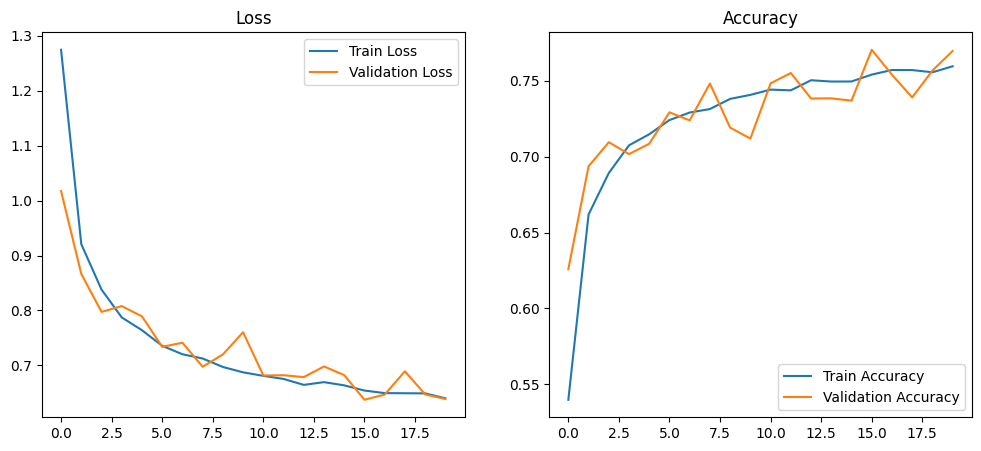

In [27]:
# Afișează graficele
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()
